datasource : https://www.kaggle.com/datasets/ananysharma/indian-names-dataset/data

In [26]:
words = open('data/names.txt', 'r').read().splitlines()
words[:5]

['mahipal', 'nanhe', 'vashudev', 'nandni', 'divya']

In [27]:
len(words)

29823

In [28]:
min(len(w) for w in words), max(len(w) for w in words)

(3, 19)

In [31]:
import torch

# Create a Bigram Count Matrix

In [79]:
# Initialize a 27x27 tensor of zeros (int32)
N = torch.zeros((27, 27), dtype=torch.int32)

# Create sorted list of unique characters from all words
unique_chars = sorted(set(''.join(words)))

# Add the special character '.' at the beginning
itos = ['.'] + unique_chars
stoi = {ch: idx for idx, ch in enumerate(itos)}
itos = {idx: ch for ch, idx in stoi.items()}

In [80]:
for word in words:
    chars = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

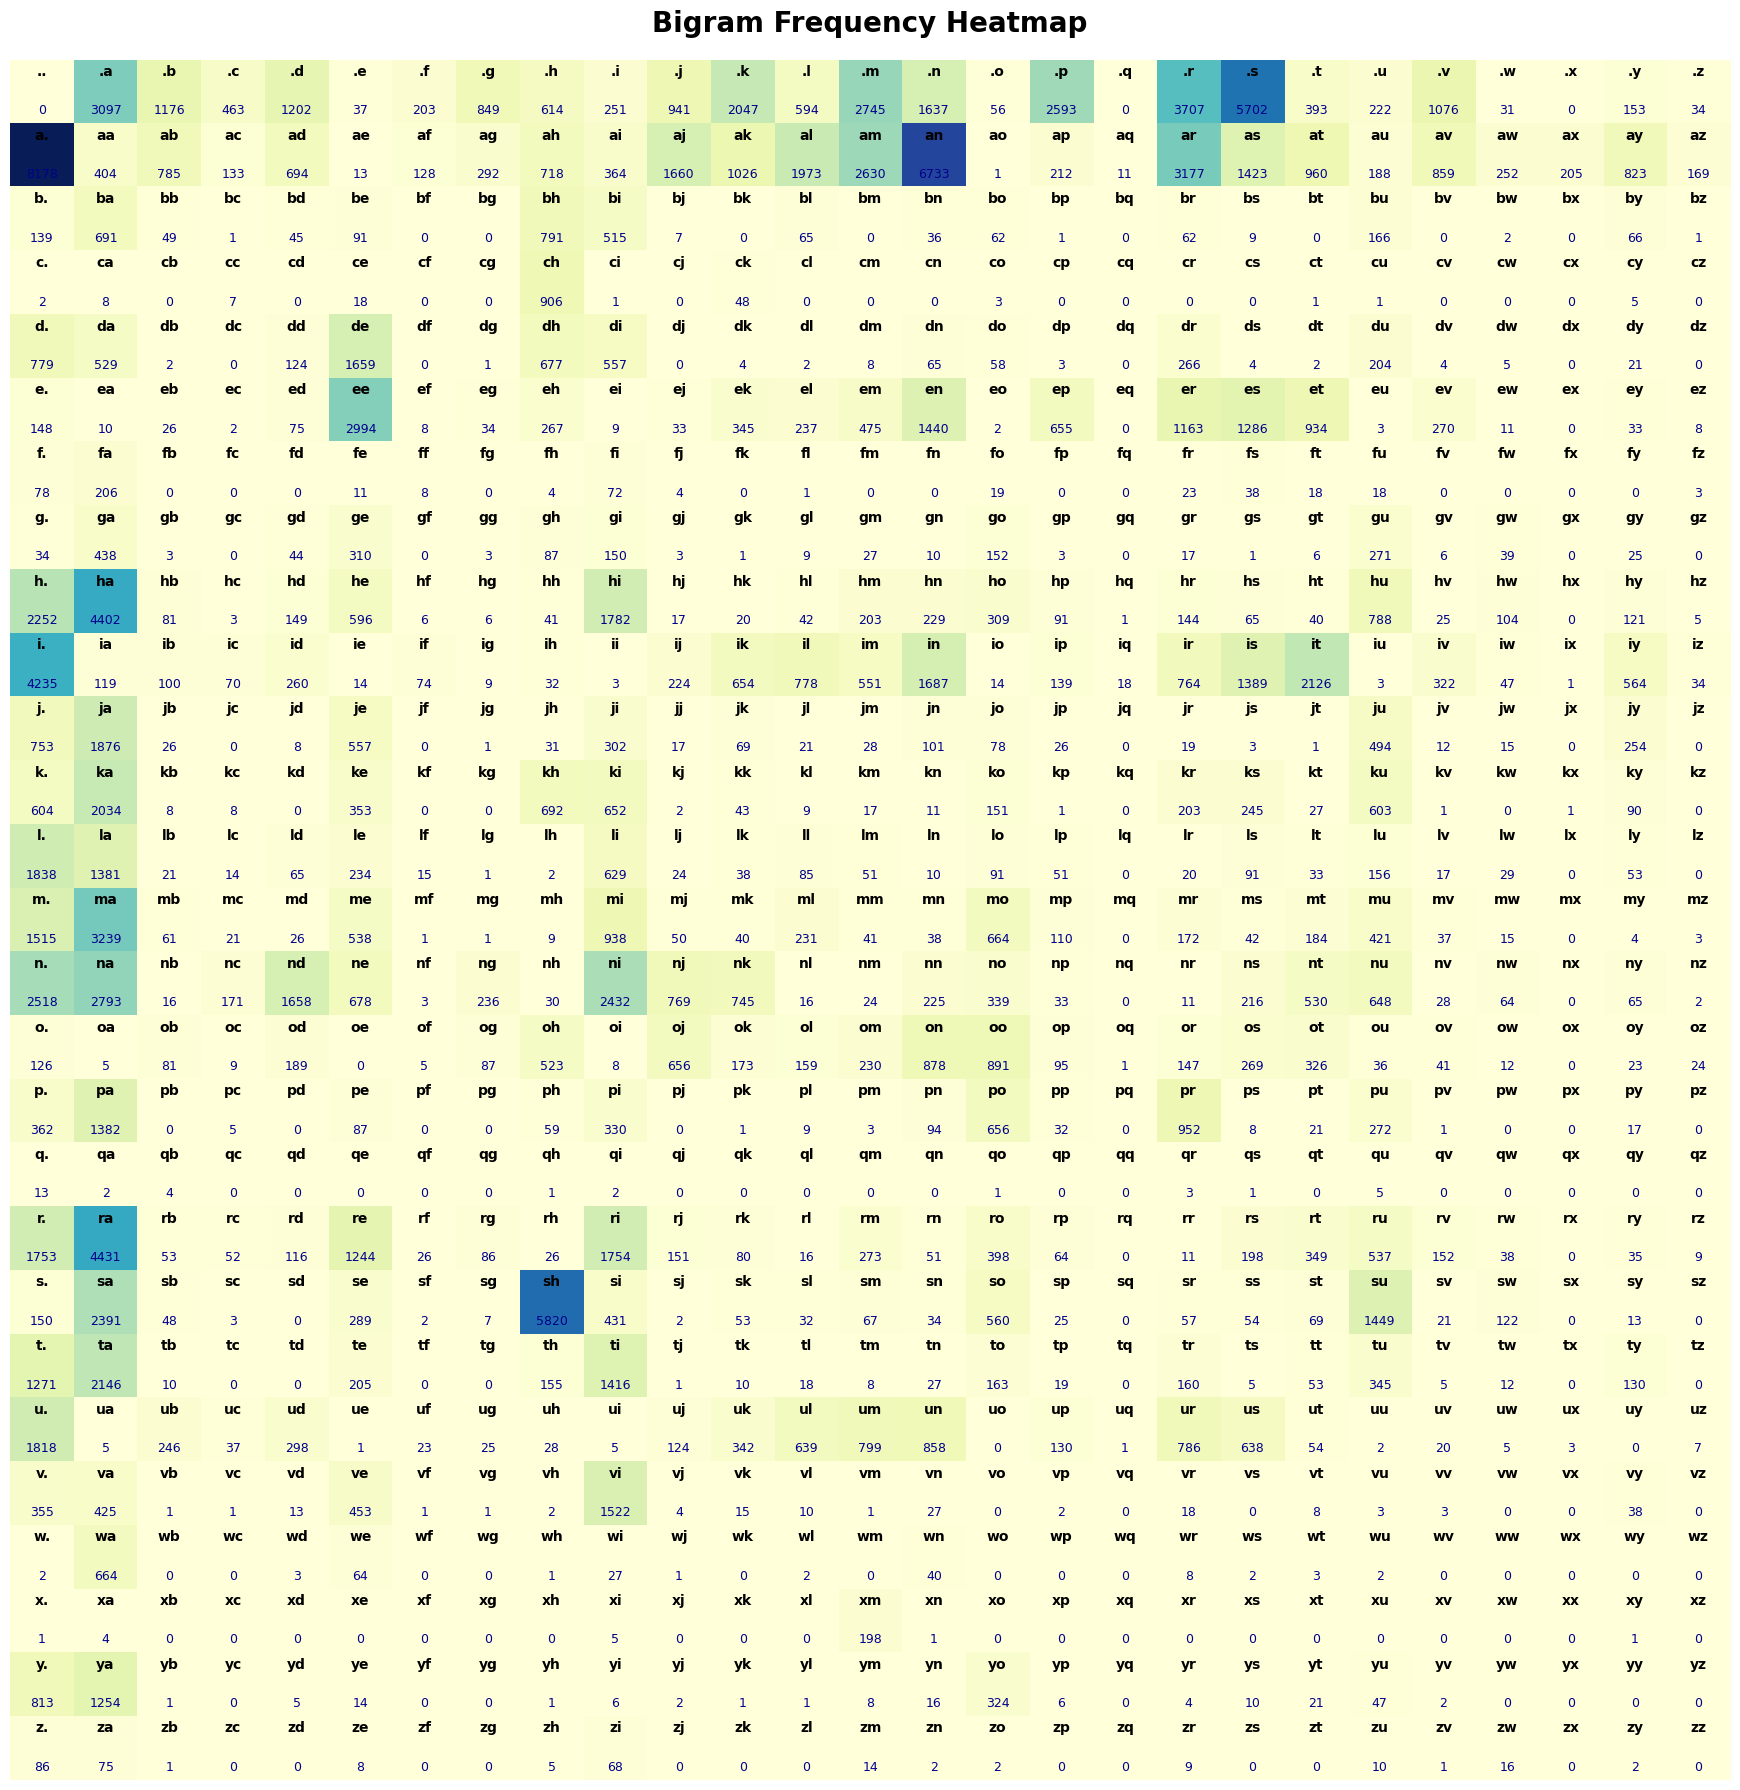

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
plt.imshow(N, cmap='YlGnBu')  # Softer gradient colormap

# Add grid lines
plt.grid(which='both', color='white', linewidth=0.5)
plt.xticks(range(27), [itos[i] for i in range(27)], fontsize=12)
plt.yticks(range(27), [itos[i] for i in range(27)], fontsize=12)

# Draw annotations
for i in range(27):
    for j in range(27):
        count = N[i, j].item()
        
        pair = f"{itos[i]}{itos[j]}"
        plt.text(j, i - 0.2, pair, ha="center", va="bottom", color='black', fontsize=10, fontweight='bold')
        plt.text(j, i + 0.2, count, ha="center", va="top", color='darkblue', fontsize=9)

plt.title("Bigram Frequency Heatmap", fontsize=20, weight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("bigram_heatmap.png")
plt.show()

In [42]:
N[0]

tensor([   0, 3097, 1176,  463, 1202,   37,  203,  849,  614,  251,  941, 2047,
         594, 2745, 1637,   56, 2593,    0, 3707, 5702,  393,  222, 1076,   31,
           0,  153,   34], dtype=torch.int32)

# Convert Counts to Probabilities

In [44]:
# Normalizing or creating probablitiy distribution
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1038, 0.0394, 0.0155, 0.0403, 0.0012, 0.0068, 0.0285, 0.0206,
        0.0084, 0.0316, 0.0686, 0.0199, 0.0920, 0.0549, 0.0019, 0.0869, 0.0000,
        0.1243, 0.1912, 0.0132, 0.0074, 0.0361, 0.0010, 0.0000, 0.0051, 0.0011])

In [65]:
# lets sample out from the above probablility distribution 
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'd'

In [66]:
# Now lets calculate the row wise probability distribution 
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [69]:
P.shape

torch.Size([27, 27])

In [87]:
# Generate names using the learned bigram distribution
generator = torch.Generator().manual_seed(2147483647)

num_names = 5
for _ in range(num_names):
    name = []
    idx = 0  # Start with the special token '.'
    
    while True:
        probs = P[idx]
        # probs = torch.ones(27)/27.0 # uniform distribution
        
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
        name.append(itos[idx])
        if idx == 0:
            break  # End token reached

    print(''.join(name))

deend.
poml.
urarohakay.
n.
pojimititinjakavi.


# Part 3: Model Evaluation

In [88]:
log_likelihood = 0.0
total_transitions = 0

for word in words:
    chars = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        log_likelihood += torch.log(prob)
        total_transitions += 1

nll = -log_likelihood
avg_nll = nll / total_transitions

print(f'Log Likelihood: {log_likelihood:.4f}')
print(f'Negative Log Likelihood (NLL): {nll:.4f}')
print(f'Average NLL per transition: {avg_nll:.4f}')


Log Likelihood: -444742.1875
Negative Log Likelihood (NLL): 444742.1875
Average NLL per transition: 2.2044
